In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = "./data/1970_5.xlsx"

def read_excel(path):

    df = pd.read_excel(path, header=None)
    data = df.values
    data = np.delete(data, 0, axis=0)
    return data

data = read_excel(file_path)

print(data)

dict_level = {}
for i in range(len(data)):
    if dict_level.__contains__(data[i][1]):
        if dict_level[data[i][1]] < data[i][10]:
            dict_level[data[i][1]] = data[i][10]
    else:
        dict_level[data[i][1]] = data[i][10]

print(len(dict_level))


[[2944 1970 1 ... nan '云南通海' '云南玉溪市通海县']
 [2945 1970 1 ... nan '云南通海西' '云南玉溪市红塔区']
 [2946 1970 1 ... nan '云南通海西' '云南玉溪市红塔区']
 ...
 [5005 2018 12 ... nan '四川兴文' '四川宜宾市兴文县']
 [5006 2018 12 ... nan '新疆阿克陶' '新疆克孜勒苏柯尔克孜自治州阿克陶县']
 [5007 2018 12 ... nan '西藏谢通门' '西藏日喀则市谢通门县']]
49


[7.8, 6.7, 8, 7.7, 7.3, 7.3, 7.8, 6.6, 7.3, 6.8, 6.7, 6.9, 6.6, 6.9, 6.3, 7.1, 7.3, 6.4, 7.4, 6.7, 7.2, 6.7, 6.9, 6.6, 7.3, 7.3, 7.1, 7.5, 6.6, 7.6, 6.8, 8.1, 7.5, 7.9, 6.7, 6.5, 7.2, 6.6, 8, 6.7, 7.1, 7.2, 6.6, 7, 7.3, 8.1, 6.7, 7, 6.5]
[7.15077019 7.17635822 7.10231781 7.21898603 7.26680613]


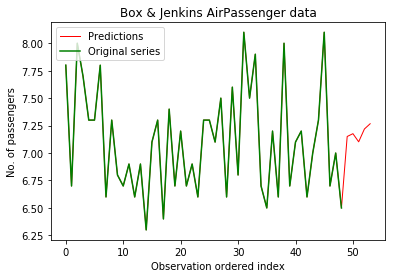

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
import logging

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)


class TimeSeriesNnet(object):
    def __init__(self, hidden_layers=[20, 15, 5], activation_functions=['relu', 'relu', 'relu'],
                 optimizer=SGD(), loss='mean_absolute_error'):
        self.hidden_layers = hidden_layers
        self.activation_functions = activation_functions
        self.optimizer = optimizer
        self.loss = loss

        if len(self.hidden_layers) != len(self.activation_functions):
            raise Exception("hidden_layers size must match activation_functions size")

    def fit(self, timeseries, lag=15, epochs=10000, verbose=0):
        self.timeseries = np.array(timeseries, dtype="float64")  # Apply log transformation por variance stationarity
        self.lag = lag
        self.n = len(timeseries)
        if self.lag >= self.n:
            raise ValueError("Lag is higher than length of the timeseries")
        self.X = np.zeros((self.n - self.lag, self.lag), dtype="float64")
        self.y = np.log(self.timeseries[self.lag:])
        self.epochs = epochs
        self.scaler = StandardScaler()
        self.verbose = verbose


        # Building X matrix
        for i in range(0, self.n - lag):
            self.X[i, :] = self.timeseries[range(i, i + lag)]


        self.scaler.fit(self.X)
        self.X = self.scaler.transform(self.X)


        # Neural net architecture
        self.nn = Sequential()
        self.nn.add(Dense(self.hidden_layers[0], input_shape=(self.X.shape[1],)))
        self.nn.add(Activation(self.activation_functions[0]))

        for layer_size, activation_function in zip(self.hidden_layers[1:], self.activation_functions[1:]):
            self.nn.add(Dense(layer_size))
            self.nn.add(Activation(activation_function))

        # Add final node
        self.nn.add(Dense(1))
        self.nn.add(Activation('linear'))
        self.nn.compile(loss=self.loss, optimizer=self.optimizer)

        # Train neural net
        self.nn.fit(self.X, self.y, epochs=self.epochs, verbose=self.verbose)

    def predict_ahead(self, n_ahead=1):
        # Store predictions and predict iteratively
        self.predictions = np.zeros(n_ahead)

        for i in range(n_ahead):
            self.current_x = self.timeseries[-self.lag:]
            self.current_x = self.current_x.reshape((1, self.lag))
            self.current_x = self.scaler.transform(self.current_x)
            self.next_pred = self.nn.predict(self.current_x)
            self.predictions[i] = np.exp(self.next_pred[0, 0])
            self.timeseries = np.concatenate((self.timeseries, np.exp(self.next_pred[0, :])), axis=0)

        return self.predictions

#生成模型并预测
def predict_flow(time_series):
    neural_net = TimeSeriesNnet(hidden_layers=[20, 15, 5],activation_functions=['sigmoid', 'sigmoid', 'sigmoid'])  # 隐藏层每层的神经元格式以及激活函数
    neural_net.fit(time_series, lag=15, epochs=1000)  # epochs代表迭代次数
    predictions=neural_net.predict_ahead(n_ahead = 5)#预测接下来x天的值
    print(predictions)
    pre_loss=neural_net.loss#返回的是损失函数类型，不是误差。估计要自己定义计算误差的函数。
    #print(pre_loss)
    return neural_net,predictions,pre_loss

#图形化显示结果
def show_predicted_flow(neural_net,time_series):
    plt.plot(range(len(neural_net.timeseries)), neural_net.timeseries, '-r', label='Predictions', linewidth=1)
    plt.plot(range(len(time_series)), time_series, '-g',  label='Original series')
    plt.title("Box & Jenkins AirPassenger data")
    plt.xlabel("Observation ordered index")
    plt.ylabel("No. of passengers")
    plt.legend()
    plt.show()


time_series = []
for k, v in dict_level.items():
    time_series.append(v)
print(time_series)

neural_net, predictions, pre_loss=predict_flow(time_series)
show_predicted_flow(neural_net,time_series)